# HESG Data usage - 2 - heating status and consumption

## Introduction

This notebook is part of the HESG Data Usage package. Please refer to the whole repository available here:  
https://gitlab.com/es-catapult-ds/hesg-data-examples

Please refer to this repository for the license, python packages requirement and how to access data.

## Content of this notebook

This notebook shows an example of how access and use the HESG Data to display the status of the boiler and observed gas consumption of a specific household.

It is assumed that the following files are in the working directory:
- eden1sensor.csv

## 1. Import the libraries

In [1]:
# CSV files are loaded with pandas
import pandas as pd

# plotting is done with matplotlib
import matplotlib.pyplot as plt
# this jupyter notebook command enables interactive plotting
%matplotlib notebook
# remove SettingWithCopyWarning warning message to avoid distraction
pd.set_option('mode.chained_assignment', None)

## 2. Load "sensor" with filtering

Similarly to what was done in the previous notebook, the csv will be loaded with some filtering.

If you load the whole sensor.csv file, this will take time and use a lot of RAM.  The strategy here is to load the file chunk by chunk, and for each chunk, apply some filtering to reduce the amount of data kept in memory.

In the following example, the only data that is kept is the one for which houseid==76 and the data recorded in March 2019.

Once it is done, the data will saved in a file name "df_sensor_selected.csv" in the current working directory. If the cell is executed a second time, it is this file that is loaded instead, fastening the process.

In [2]:
# load one month of one house from the whole sensor file
try:
    # the file already exist, so, no need to redo the whole filtering
    df_sensor_selected = pd.read_csv("./df_sensor_selected.csv")
except FileNotFoundError:
    # we load chunk by chunk, each chunk having 1'000'000 rows
    chunksize = 1000000
    filename = "./eden1sensor.csv"
    chunks = []
    houseid = 76
    # We can restrict the DataFrame size by listing the column names
    # that we will use. The other columns will not be loaded in memory.
    useful_cols = ["houseid", "roomid", "sensortimestamp",
                   "roomtype",
                   "roomtimestamp",
                   "roomtemperature",
                   "roomdatastatus",
                   "radiator1surfacetemp",
                   "radiator1datastatus",
                   "radiator1timestamp",
                   "wrvswitchvariable",
                   "wrvdatastatus",
                   "wrvtimestamp",
                   "boilerdatastatus",
                   "boilerswitchonoff",
                   "boilertimestamp",
                   "gasmeterdatastatus",
                   "gasmeterreading",
                   "gasmetertimestamp",
                   "hotwaterdatastatus",
                   "hotwaterflowtemp",
                   "hotwaterreturn",
                   "hotwatertimestamp"
                   ]
    for chunk in pd.read_csv(filename,
                             usecols = useful_cols,
                             chunksize=chunksize):
        chunk = chunk[chunk["houseid"] == houseid]
        chunk["sensortimestamp"] =  pd.to_datetime(chunk["sensortimestamp"])
        chunk = chunk[(chunk["sensortimestamp"] >= "1 Mar 2019")
                     & (chunk["sensortimestamp"] < "1 Apr 2019")]
        
        print("loaded", len(chunk), "lines")
        if len(chunk):
            chunks.append(chunk)
    if len(chunks) == 1:
        df_sensor_selected = chunks[0]
    elif len(chunks) >= 2:
        df_sensor_selected = pd.concat(chunks)
    else:
        print("no line loaded")
    del chunks
    print("save it in a file for fast loading")
    df_sensor_selected.to_csv("./df_sensor_selected.csv", index=False) 

/home/caudron/anaconda3/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (3,4,5,6,8,9,12,13,15,16,18,19,20,22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# the room id are translated into a more human-readable format. 
df_rooms = df_sensor_selected.groupby("roomid").first()
df_rooms["roomtype_indice"] = df_rooms.groupby("roomtype").cumcount()
df_rooms["roomname2"] = (df_rooms["roomtype"].astype(str).str.replace(" & ", "")
                         + df_rooms["roomtype_indice"].astype(str))
df_rooms = df_rooms[["roomname2"]]
df_sensor_selected["roomid"] = df_sensor_selected["roomid"].replace(df_rooms["roomname2"].to_dict())

## 3. Plot the room temperature and the valve status

The room temperature and the valve status is plotted, as done in full details in the previous notebook.

In [4]:
df_sensor_room = df_sensor_selected[df_sensor_selected["roomid"] == "Bedrooms0"]
df_roombox = df_sensor_room[["roomtimestamp",
                            "roomtemperature",
                            "roomdatastatus"]]
df_roombox["roomtimestamp"] = pd.to_datetime(df_roombox["roomtimestamp"])
df_roombox = df_roombox[df_roombox["roomdatastatus"] == "normal"]
period = ["5 Mar 2019", "7 Mar 2019"]
df_roombox = df_roombox[(df_roombox["roomtimestamp"] >= period[0]) 
                        & (df_roombox["roomtimestamp"] < period[1])]
df_rad1 = df_sensor_room[["radiator1surfacetemp",
                          "radiator1datastatus",
                          "radiator1timestamp"]]
df_rad1 = df_rad1[df_rad1["radiator1datastatus"] == "normal"]
df_rad1["radiator1timestamp"] = pd.to_datetime(df_rad1["radiator1timestamp"])
df_rad1 = df_rad1[(df_rad1["radiator1timestamp"] >= period[0]) 
                  & (df_rad1["radiator1timestamp"] < period[1])]
df_wrv = df_sensor_room[["wrvswitchvariable",
                         "wrvdatastatus",
                         "wrvtimestamp"]]
df_wrv = df_wrv[df_wrv["wrvdatastatus"] == "normal"]
df_wrv["wrvtimestamp"] = pd.to_datetime(df_wrv["wrvtimestamp"])
df_wrv = df_wrv[(df_wrv["wrvtimestamp"] >= period[0]) 
                & (df_wrv["wrvtimestamp"] < period[1])]

<IPython.core.display.Javascript object>


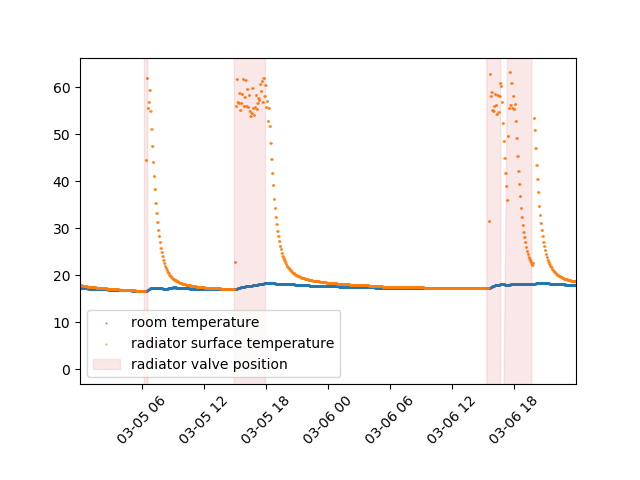

In [5]:
plt.close()
plt.scatter(df_roombox["roomtimestamp"], df_roombox["roomtemperature"],
           s=0.5, alpha=0.5, color="tab:blue", label="room temperature")
plt.scatter(df_rad1["radiator1timestamp"], df_rad1["radiator1surfacetemp"],
           s=0.5, alpha=0.5, color="tab:orange", label="radiator surface temperature")
plt.fill_between(df_wrv["wrvtimestamp"], [0]*len(df_wrv["wrvtimestamp"]), df_wrv["wrvswitchvariable"],
                 transform=plt.gca().get_xaxis_transform(),
                 alpha=0.1, color="tab:red", label="radiator valve position")
plt.xticks(rotation=45)
plt.xlim([df_roombox["roomtimestamp"].min(), df_roombox["roomtimestamp"].max()])
plt.subplots_adjust(bottom=0.2)
plt.legend()

## 4. Select and plot the boiler status, the gas meter consumption and the hot water temperature

The boiler status, the gas meter readings and the hot water temperature are obtained from "df_sensor_selected" (they are not associated with the room id "Bedrooms0")

In [6]:
# boiler status
df_boiler = df_sensor_selected[["boilerdatastatus",
                               "boilerswitchonoff",
                               "boilertimestamp"]]
df_boiler["boilertimestamp"] = pd.to_datetime(df_boiler["boilertimestamp"])
df_boiler = df_boiler[df_boiler["boilerdatastatus"] == "normal"]
df_boiler = df_boiler[(df_boiler["boilertimestamp"] >= period[0]) 
                      & (df_boiler["boilertimestamp"] < period[1])]
df_boiler

boilerdatastatus boilerswitchonoff           boilertimestamp
585843           normal             False 2019-03-05 00:00:58+00:00
585844           normal             False 2019-03-05 00:01:49+00:00
585845           normal             False 2019-03-05 00:02:58+00:00
585847           normal             False 2019-03-05 00:04:07+00:00
585848           normal             False 2019-03-05 00:05:16+00:00
...                 ...               ...                       ...
588716           normal             False 2019-03-06 23:53:33+00:00
588717           normal             False 2019-03-06 23:54:41+00:00
588718           normal             False 2019-03-06 23:55:49+00:00
588720           normal             False 2019-03-06 23:57:10+00:00
588722           normal             False 2019-03-06 23:59:16+00:00

[2155 rows x 3 columns]

In [7]:
# gas meter
df_gasmeter = df_sensor_selected[["gasmeterdatastatus",
                               "gasmeterreading",
                               "gasmetertimestamp"]]
df_gasmeter["gasmetertimestamp"] = pd.to_datetime(df_gasmeter["gasmetertimestamp"])
df_gasmeter = df_gasmeter[df_gasmeter["gasmeterdatastatus"] == "normal"]
df_gasmeter = df_gasmeter[(df_gasmeter["gasmetertimestamp"] >= period[0]) 
                      & (df_gasmeter["gasmetertimestamp"] < period[1])]
df_gasmeter

gasmeterdatastatus  gasmeterreading         gasmetertimestamp
585847             normal          4183.90 2019-03-05 00:04:51+00:00
585853             normal          4183.90 2019-03-05 00:04:51+00:00
585862             normal          4183.90 2019-03-05 00:19:59+00:00
585863             normal          4183.90 2019-03-05 00:19:59+00:00
585874             normal          4183.90 2019-03-05 00:19:59+00:00
...                   ...              ...                       ...
588698             normal          4193.03 2019-03-06 23:35:06+00:00
588700             normal          4193.03 2019-03-06 23:35:06+00:00
588710             normal          4193.03 2019-03-06 23:35:06+00:00
588712             normal          4193.03 2019-03-06 23:49:45+00:00
588720             normal          4193.03 2019-03-06 23:49:45+00:00

[463 rows x 3 columns]

In [8]:
# hot water
df_hw = df_sensor_selected[["hotwaterdatastatus",
                            "hotwaterflowtemp",
                            "hotwaterreturn",
                            "hotwatertimestamp"]]
df_hw["hotwatertimestamp"] = pd.to_datetime(df_hw["hotwatertimestamp"])
df_hw = df_hw[df_hw["hotwaterdatastatus"] == "normal"]
df_hw = df_hw[(df_hw["hotwatertimestamp"] >= period[0]) 
              & (df_hw["hotwatertimestamp"] < period[1])]
df_hw

hotwaterdatastatus  hotwaterflowtemp  hotwaterreturn  \
585843             normal             26.68           24.43   
585844             normal             26.43           24.37   
585845             normal             26.43           24.37   
585846             normal             26.43           24.37   
585847             normal             26.43           24.37   
...                   ...               ...             ...   
588718             normal             26.25           24.18   
588719             normal             26.25           24.18   
588720             normal             26.25           24.18   
588721             normal             26.25           24.18   
588722             normal             26.25           24.18   

               hotwatertimestamp  
585843 2019-03-05 00:00:03+00:00  
585844 2019-03-05 00:01:03+00:00  
585845 2019-03-05 00:02:03+00:00  
585846 2019-03-05 00:03:03+00:00  
585847 2019-03-05 00:04:04+00:00  
...                          ...  
588718 2019-03-06 23:55:56+00:00  
588719 2019-03-06 23:56:56+00:00  
588720 2019-03-06 23:56:56+00:00  
588721 2019-03-06 23:58:56+00:00  
588722 2019-03-06 23:59:56+00:00  

[2875 rows x 4 columns]

<IPython.core.display.Javascript object>


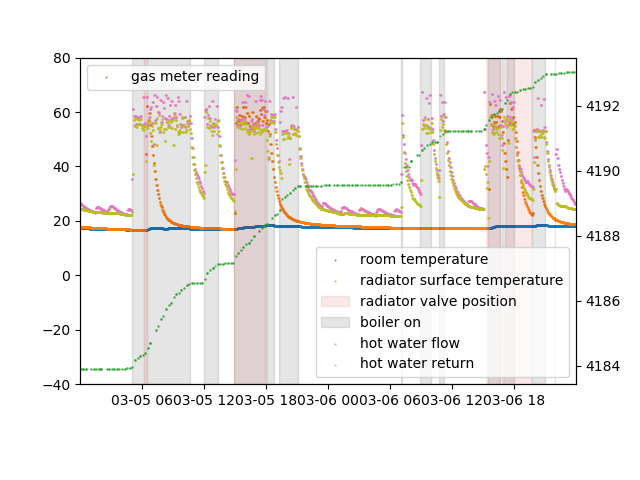

In [9]:
plt.close()
plt.scatter(df_roombox["roomtimestamp"], df_roombox["roomtemperature"],
           s=0.5, alpha=0.5, color="tab:blue", label="room temperature")
plt.scatter(df_rad1["radiator1timestamp"], df_rad1["radiator1surfacetemp"],
           s=0.5, alpha=0.5, color="tab:orange", label="radiator surface temperature")
plt.fill_between(df_wrv["wrvtimestamp"], [0]*len(df_wrv["wrvtimestamp"]), df_wrv["wrvswitchvariable"],
                 transform=plt.gca().get_xaxis_transform(),
                 alpha=0.1, color="tab:red", label="radiator valve position")
plt.fill_between(df_boiler["boilertimestamp"], 0, 1, where=df_boiler["boilerswitchonoff"],
                 transform=plt.gca().get_xaxis_transform(),
                 alpha=0.1, color="black", label="boiler on")
plt.scatter(df_hw["hotwatertimestamp"], df_hw["hotwaterflowtemp"],
           s=0.5, alpha=0.5, color="tab:pink", label="hot water flow")
plt.scatter(df_hw["hotwatertimestamp"], df_hw["hotwaterreturn"],
           s=0.5, alpha=0.5, color="tab:olive", label="hot water return")
plt.legend(loc="lower right")
plt.ylim([-40, 80])
ax2 = plt.gca().twinx()
ax2.scatter(df_gasmeter["gasmetertimestamp"], df_gasmeter["gasmeterreading"],
           s=0.5, alpha=0.5, color="tab:green", label="gas meter reading")

plt.xticks(rotation=45)
plt.xlim([df_roombox["roomtimestamp"].min(), df_roombox["roomtimestamp"].max()])
plt.subplots_adjust(bottom=0.2)
plt.legend()

## 5. Some interesting remarks
1) the radiator get hot only if both boiler and valve are open

2) the gasmeter counter increases when the gas boiler is used, but also increases when the gas is used for other purpose (domestic hot water, possible gas cooking, ...).

3) the hot water flow temperature is higher than the hot water return temperature, and radiator surface temperature is more or less between the two, or slightly lower.

4) the hot water flow temperature can increase a bit when in fact it is the domestic hot water that gets hot. The reason is that the sensor is stuck to the hot water flow pipe, but the domestic hot paper pipes can be next to it, and the sensor can pick up the heat emitted from this pipe.

## 6. Information to clean the data

1) For each sensor, the data status should not be abnormal: ...datastatus == "normal"

2) Some temperature sensors may say < -200 degree. This is obviously incorrect

3) Some boiler status can say the boiler is on, but if hot water flow temperature is not > 30, it is incorrect

4) The gas meter readings are often problematic. A lot of the recording are flat-lining or absent

## 7. Information about the resolution

room temperature sensor: every ~1 min

radiator surface temperature: every ~5 min

hot water temperature: every ~5 min

radiator valve: every ~15 min

gas meter readings: every ~15 min

gas boiler switch: every ~1 min